## Chapter 13: Multi-layer Perceptrons 

# 13.7 Cross-Validation via Early Stopping

The standard regularization procedure for cross-validation presented in Section 11.4 requires many complete minimizations of the given cost function in order to determine the optimal setting of model weights. However optimization of neural networks (particularly those employing many hidden layers) can be challenging and computationally intensive, making cross-validation via the typical regularization approach very difficult. In this Section we introduce an alternative regularization technique called *early stopping* that is commonly used with neural network models. Early stopping presents a comparatively cheap alternative for regularizing network models, where optimal parameters are chosen from a single optimization run by halting it when validation error is at its lowest.

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_13_library') 
sys.path.append('./chapter_13_images') 
sys.path.append('./chapter_13_datasets') 

# backend file
import static_plotter, basic_runner, early_stop_classification_animator, early_stop_regression_animator
import nonlinear_regression_demos_multiple_panels as regress_plotter
import nonlinear_classification_visualizer_multiple_panels as classif_plotter
import crossval_classification_visualizer as classif_plotter_crossval

from early_stop_demo_lib import superlearn_setup

# data path
data_path_1 = 'chapter_13_datasets/noisy_sin_sample.csv'
data_path_2 = 'chapter_13_datasets/new_circle_data.csv'
data_path_3 = 'chapter_13_datasets/early_stopping_weights.p'
data_path_4 = 'chapter_13_datasets/early_stop_test_data.p'
data_path_5 = 'chapter_13_datasets/early_stop_train_data.p'
data_path_6 = 'chapter_13_datasets/MNIST_subset.pickle'

# image paths
image_path_1 = "chapter_13_images/early_stopping_part_1.png"
image_path_2 = "chapter_13_images/early_stopping_part_2.png"

# video paths
video_path_1 = 'chapter_13_videos/animation_5.mp4'
video_path_2 = 'chapter_13_videos/animation_5.mp4'

# plotting imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Early stopping

With any technique for cross-validation (introduced in Section 11.2) our ideal is to find a model that provides the lowest possible error on a validation set. With early stopping we do this by stopping the minimization of a cost function (which is measuring training error) when validation error reaches its lowest point. The basic idea is illustrated in the figure below. In the left panel we show a prototypical nonlinear regression dataset, and in the middle the cost function of a high capacity model (like a deep neural network) shown figuratively in two dimensions. As we begin a run of a local optimization method we measure both the training error (provided by the cost function we are minimizing) as well as validation error at each step of the procedure, as shown in the right panel. We try to halt the procedure when the validation error has reached its lowest point. This *regularization technique* is commonly used as a cheap alternative to the standard approach outlined in Section 11.4, particularly with deep neural network models that can be difficult to optimize, as it requires only a single optimization run.

In [2]:
IPython.display.HTML('''<img src="''' + image_path_1 + '''" width="100%" height="auto" alt=""/>''')

<figure>
<figcaption> <strong>Figure 1:</strong> <em> (left panel) A prototypical nonlinear regression dataset, (middle panel) a figurative illustration of the cost associated with a high capacity model, and the measurement of training / validation error at each step of a local optimization procedure.  With *early stopping* we make a run of a local optimization procedure and measure both the training and validation error at each step.  We try to halt the procedure when the validation error reaches its lowest value, with the corresponding set of weights providing our high capacity  `model` with the least chance of overfitting our training data (and hopefully providing a good fit to the entire dataset).
</em>
</figcaption>
</figure>

There are a number of important engineering details associated with making an effective early stopping procedure. These include 

- **When is validation error really at its lowest?** While generally speaking validation error decreases at the start of an optimization run and eventually increases (making somewhat of a 'U' shape) it can certainly fluctuate up and down during optimization. Therefore it is not all together obvious when the validation error has indeed reached its lowest point unless the optimization process is performed to completion. To deal with this peculiarity, often in practice a reasonable engineering choice is made as to when to stop based on how long it has been since the validation error has *not* decreased.


- **Large (local optimization) steps are to be avoided.** The idea with early stopping is to measure training and validation errors often as an optimization procedure makes progress, so that the procedure can be halted when validation error is low. If one uses a local optimization procedure that takes very large steps (e.g., Newton's method) optimization can quickly lead to weights that overfit the training data. In other words, a set of weights that provide minimal validation error can be skipped over entirely. Thus when employing early stopping one needs to use a local optimization method with moderate-length steps.


- **Validation error should be measured often.** Validation error should be measured frequently during the minimization process in order to determine a validation error minimizing set of weights.  When employing a mini-batch / stochastic first order method validation error should be measured *several times per epoch* to avoid taking too large of steps without measuring validation error (and perhaps skipping over error minimizing weights entirely).

Notice that because we are stopping our optimization procedure early based on validation error, that different weights (and correspondingly different shape nonlinearities) can be found via early stopping depending on the initialization of the local method used and the trajectory of the optimization.  This is illustrated pictorally in the figure below.

In [3]:
IPython.display.HTML('''<img src="''' + image_path_2 + '''" width="100%" height="auto" alt=""/>''')

<figure>
</figure>

Below we show a few examples employing the early stopping regularization strategy.

#### <span style="color:#a50e3e;">Example 1. </span>  Early stopping of a prototypical regression dataset

Below we illustrate the early stopping procedure using a simple nonlinear regression dataset (split into $\frac{2}{3}$ training and $\frac{1}{3}$ validation), and a (artbitrarily chosen) three hidden layer network with $10$ units per layer and the $\text{tanh}$ activation.  A single run of gradient descent is illustrated below, as you move the slider left to right you can see the resulting fit at each highlighted step of the run in the original dataset (top left), training (bottom left), and validation data (bottom right).  Moving the slider to where the validation error is lowest provides - for this training / validation split of the original data - a fine nonlinear model for the entire dataset.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(data_path_1,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# show data
demo1 = regress_plotter.Visualizer(data)
# demo1.plot_data()

# import the v1 library
mylib0 = multi.early_stop_lib.superlearn_setup.Setup(x,y)

# choose features
layer_sizes = [1,10,10,10,1]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# split into training and testing sets
mylib0.make_train_valid_split(train_portion = 0.66)

# choose cost
mylib0.choose_cost(name = 'least_squares')

# fit an optimization
mylib0.fit(max_its = 20000,alpha_choice = 10**(-1))

# animate the business
frames = 200
demo1 = multi.early_stop_regression_animator.Visualizer(data_path_1)
demo1.animate_trainval_earlystop(video_path_1,mylib0,frames,show_history = True,fps=20)

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src='""" + video_path_1 + """' type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 2. </span>  Early stopping of a prototypical classification dataset

Below we plot a prototypical nonlinear classification dataset.  We will use early stopping regularization to fine tune the capacity of a `model` consisting of $5$ single hidden layer `tanh` neural network universal approximators.

Below we illustrate a large number of gradient descent steps to tune our high capacity model for this dataset.  As you move the slider left to right you can see the resulting fit at each highlighted step of the run in the original dataset (top left), training (bottom left), and validation data (bottom right).  Moving the slider to where the validation error is lowest provides - for this training / validation split of the original data - a fine nonlinear model for the entire dataset.

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(data_path_2,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

demo2 = classif_plotter.Visualizer(csvname)
# demo2.plot_data();

init_weights = pickle.load( open(data_path_3, "rb" ) )

test_data = pickle.load( open(data_path_4, "rb" ) )
x_valid =  test_data[:-1,:]
y_valid = test_data[-1:,:] 

train_data = pickle.load( open(data_path_5, "rb" ) )
x_train =  train_data[:-1,:]
y_train = train_data[-1:,:] 

# load in data
data = np.loadtxt(data_path_2,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import the v1 library
mylib1 = superlearn_setup.Setup(x,y)

# choose features
layer_sizes = [2,5,1]

# choose features
mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

# choose normalizer
mylib1.choose_normalizer(name = 'standard')

# split into training and testing sets
mylib1.make_train_valid_split(train_portion = 0.66)

# put in saved data
mylib1.x_train = x_train
mylib1.y_train = y_train
mylib1.x_valid = x_valid
mylib1.y_valid = y_valid

# choose cost
mylib1.choose_cost(name = 'softmax',init = init_weights)

# fit an optimization
mylib1.fit(max_its = 2000,alpha_choice = 10**(0))#,init = favorite_color)

# plot cost history
#mylib1.show_histories(start = 0)

# load up animator
demo3 = multi.early_stop_classification_animator.Visualizer(data_path_2)
frames = 200
demo3.animate_trainval_earlystop(video_path_2,mylib1,frames,fps=20)

In [7]:
## This code cell will not be shown in the HTML version of this notebook
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src='""" + video_path_2 + """' type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 3. </span>  Early stopping on a subset of MNIST

In this example we illustrate the result of early stopping using a subset of $P = 10,000$ points from the MNIST dataset, employing (an arbitrarily chosen) three hidden-layer architecture with $10$ units per layer and the `relu` activation function.  Here we employ $80\%$ of the dataset for training and the remainder for validation, and run gradient descent for $3,000$ steps measuring the cost function and number of misclassifications at each stsp over both training and validation sets.

The cost function over the validation error reaches a minimum value around step $1,000$, and the misclassifications over validation reaches a mininum of $230$ around step $1,5000$. 

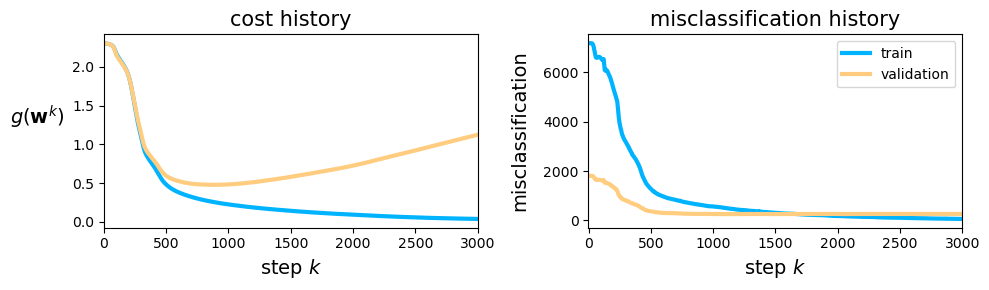

In [11]:
# This code cell will not be shown in the HTML version of this notebook
# load data
with open(data_path_6, "rb") as input_file:
    data = pickle.load(input_file)
    
x_sample = data[0]
y_sample = data[1] 

# import the v1 library
mylib2 = superlearn_setup.Setup(x_sample,y_sample)

# choose features
layer_sizes = [784,10,10,10,10]

# choose features
mylib2.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'relu')

# choose normalizer
mylib2.choose_normalizer(name = 'standard')

# split into training and testing sets
mylib2.make_train_valid_split(train_portion = 0.8)

# choose cost
mylib2.choose_cost(name = 'multiclass_softmax')

# fit an optimization
mylib2.fit(max_its = 3000,alpha_choice = 10**(-1))
mylib2.show_histories()